In [2]:
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib
import math
import hdbscan
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
import scipy

In [3]:
output_path = './Multi_F_Results'

Import results files that has Bivaraite Moran's I. 

In [4]:
state_lookup = pd.read_csv('./census_geometry/state_lookup.csv')

# mi = gpd.read_file(os.path.join(output_path, 'MH_F_mi_all.geojson'))

mi = gpd.GeoDataFrame()
for i in range(0, 15):
    temp_path = os.path.join(output_path, f'N_{i}', f'Multi_F_mi.geojson')
    if os.path.exists(temp_path):
        temp_ = gpd.read_file(temp_path)
        temp_['iter'] = i
        mi = pd.concat([mi, temp_], ignore_index=True)

mi = mi.fillna(0)
mi['STATE'] = mi.apply(lambda x:x['ID'][0:2], axis=1)
mi = mi.merge(state_lookup, left_on='STATE', right_on='Abbr', how='left')

mi.head()

,ID,LAT,LON,NAME,LIBRARY_ID,LIBRARY_TYPE,MH_F,IH_F,TAS_F,SS_F,...,pval_GROUPQ,dist_GROUPQ,geometry,iter,STATE,Name,Abbr,FIPS,ContiguousUS,Region
0,CA10114,36.416309,-119.003224,TERMINUS DAM,199,dam_study,True,False,True,True,...,1.477466e-01,25000,POINT (-119.00322 36.41631),0,CA,California,CA,6,1,Pacific
1,CA10113,36.060671,-118.919340,Richard L. Schafer Dam,98,dam_study,True,False,True,True,...,6.966340e-07,25000,POINT (-118.91934 36.06067),0,CA,California,CA,6,1,Pacific
2,NY00468,42.733294,-77.907232,MOUNT MORRIS DAM,316,dam_study,True,False,True,True,...,0.000000e+00,2500,POINT (-77.90723 42.73329),0,NY,New York,NY,36,1,MiddleAtlantic
3,CA10109,38.151041,-120.813699,NEW HOGAN DAM,297,dam_study,True,False,True,True,...,1.231008e-03,25000,POINT (-120.81370 38.15104),0,CA,California,CA,6,1,Pacific
4,CA10104,37.906801,-120.934059,FARMINGTON DAM,260,dam_study,True,False,True,True,...,0.000000e+00,2500,POINT (-120.93406 37.90680),0,CA,California,CA,6,1,Pacific


The name of the columns for Moran's I results

In [5]:
# str: single variable
# list: [[To be summed and set as numerator], demonimator]  
census_info = {
                "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
                "EP_UNEMP"  : 'DP03_0009PE',
                "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                            'S2503_C01_001E'],
                "EP_NOHSDP" : 'S0601_C01_033E',
                "EP_UNINSUR" : 'S2701_C05_001E',
                "EP_AGE65" : 'S0101_C02_030E',
                "EP_AGE17" : [['B09001_001E'], 
                            'S0601_C01_001E'],
                "EP_DISABL" : 'DP02_0072PE',
                "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
                "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                                'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                                'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                            'B16005_001E'],
                "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                                'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                            'S0601_C01_001E'],
                "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                            'DP04_0001E'],
                "EP_MOBILE" : 'DP04_0014PE',
                "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                            'DP04_0002E'],
                "EP_NOVEH" : 'DP04_0058PE',
                "EP_GROUPQ": [['B26001_001E'], 
                            'S0601_C01_001E'],
}
plot_cols_mi = ['MI_' + col.split('_')[1] for col in census_info.keys()]
plot_cols_lm = ['LISA_' + col.split('_')[1] for col in census_info.keys()]

## Overall distribution of SVI variables

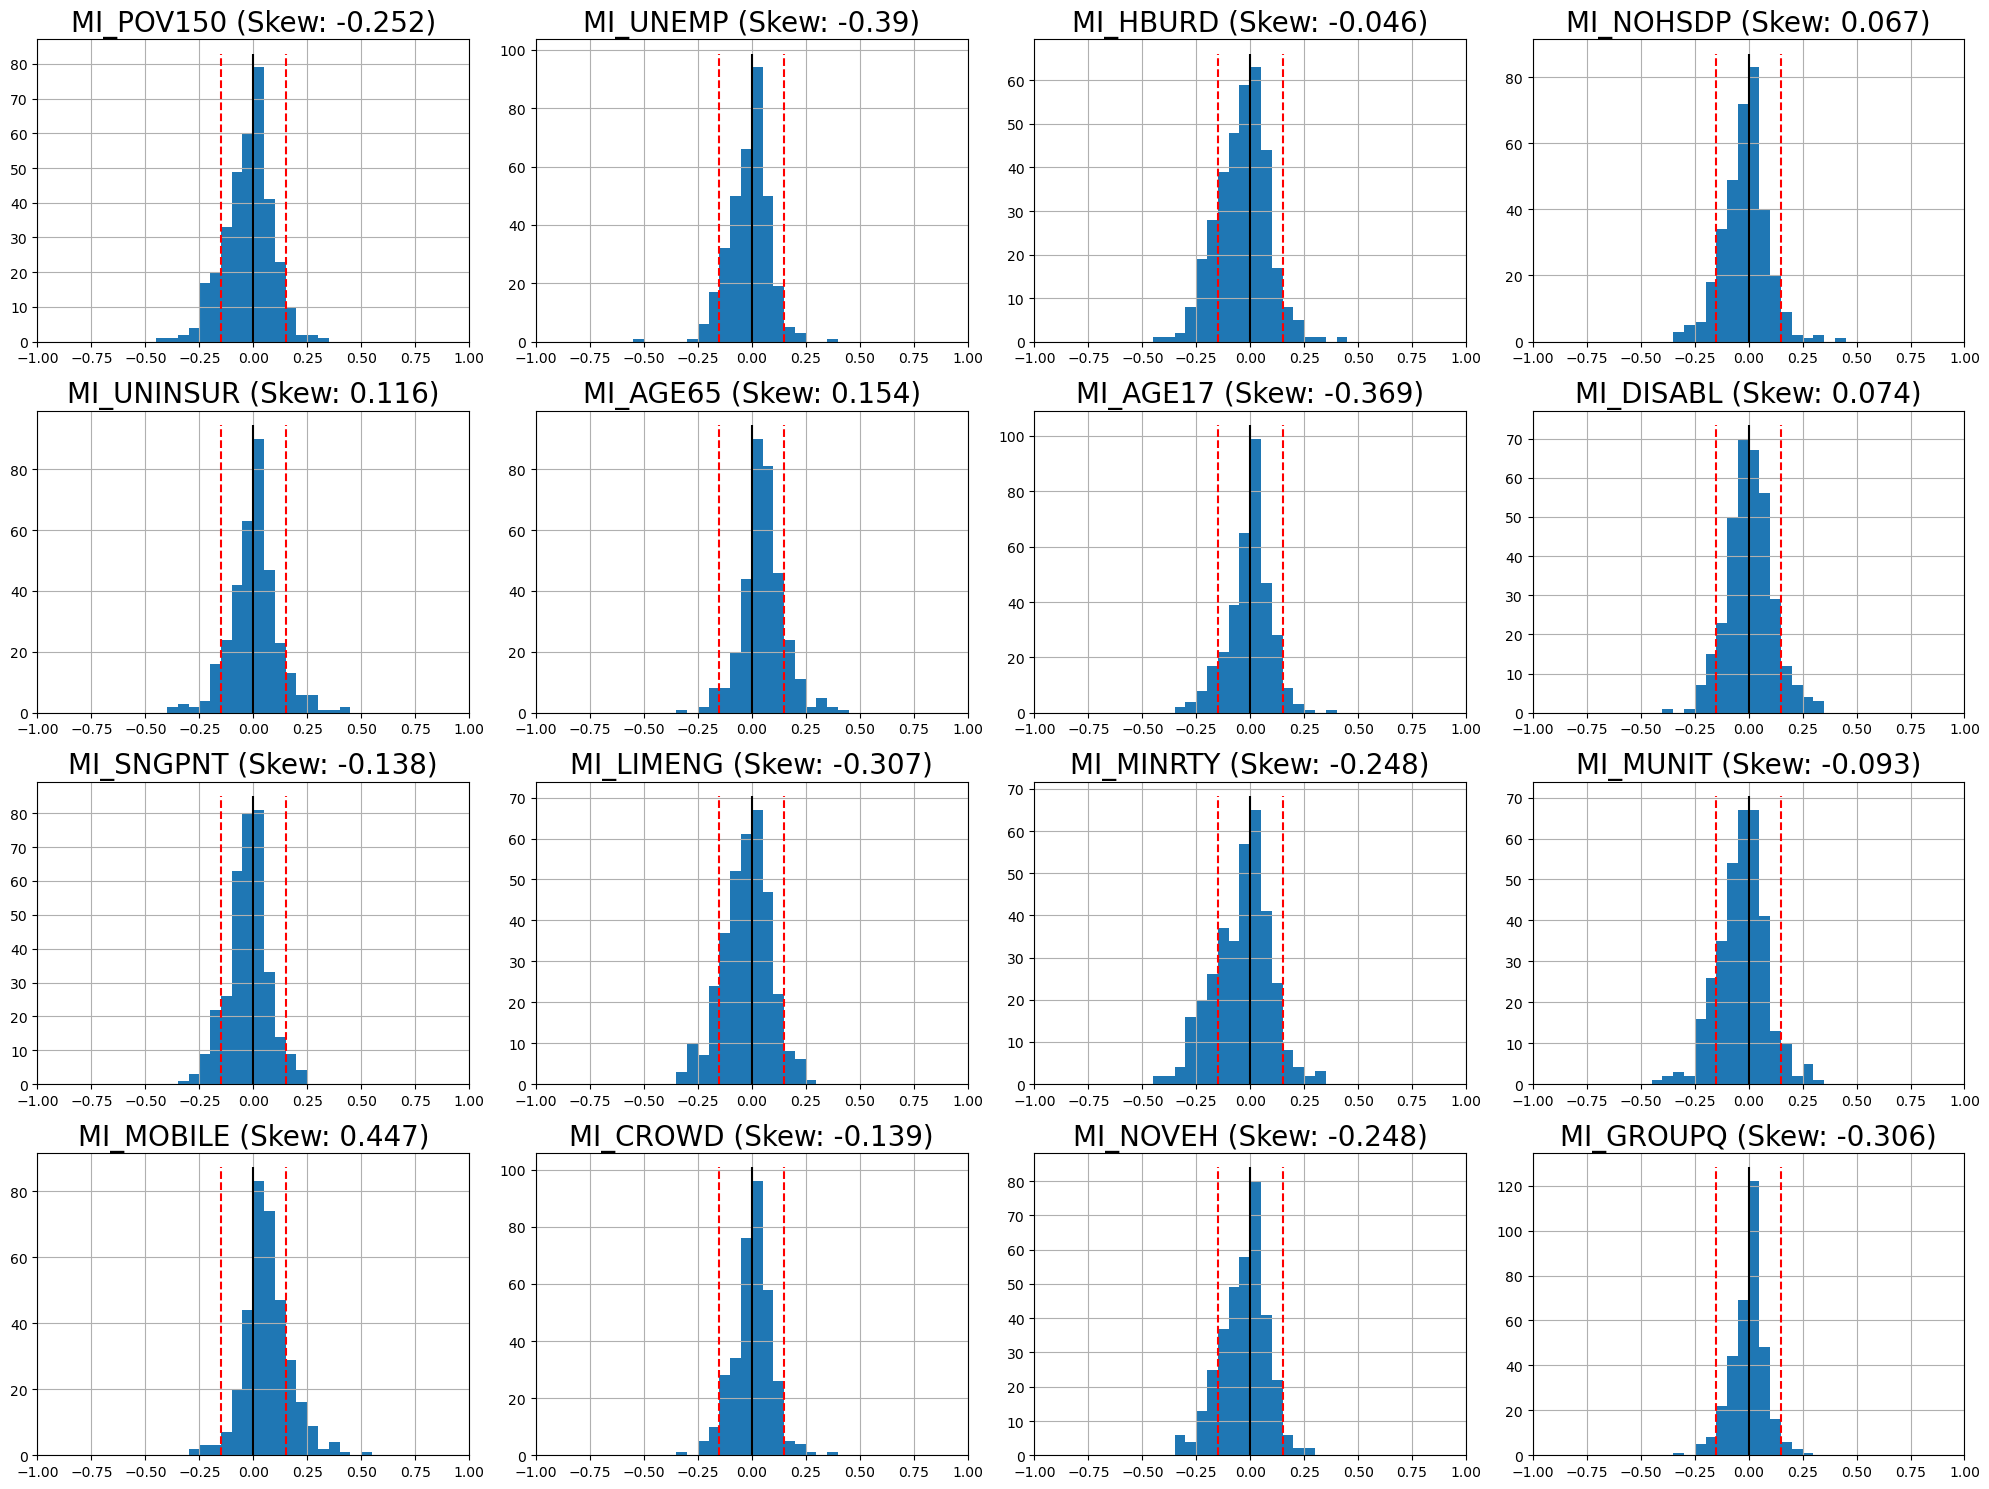

In [6]:
mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]

for col in mi_.columns:
    mi_ = mi_.loc[pd.notna(mi_[col])]
    
mi_

fig, axes = plt.subplots(4, 4, figsize=(20,15))
ax = axes.reshape(-1)

binwidth = 0.05
n = 10
for idx, col in enumerate(plot_cols_mi):
    bins = np.arange(math.floor(min(mi_[col]) * n) / n, math.ceil(max(mi_[col]) * n) / n + binwidth, binwidth)
    mi_[col].hist(ax=ax[idx], bins=bins)
    
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
#     ax[idx].vlines(mi_[col].mean(), 0, ylim, color='red')
    ax[idx].vlines(-0.15, 0, ylim, color='red', linestyle='dashed')
    ax[idx].vlines(0.15, 0, ylim, color='red', linestyle='dashed')
    
    skew_val = scipy.stats.skew(mi_[col])
    ax[idx].set_title(label=f"{col} (Skew: {round(skew_val, 3)})", fontsize=20)
    ax[idx].set_xlim(-1, 1)
    
plt.tight_layout()
plt.show()
    

## PCA for 16 Moran's I (Water level & SVI-related Census data)

In [6]:
mi_ = mi[[col for col in mi.columns if col.startswith('MI')]].reset_index(drop=True)

pca_n = 4
pca = PCA(n_components=pca_n, svd_solver='full', random_state=17)
pca_result = pca.fit_transform(mi_)
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')
print(f'Cumulative variance explained by {pca_n} principal components: {round(np.sum(pca.explained_variance_ratio_), 2)}')


Explained variation per principal component: [0.38041092 0.12823956 0.1070004  0.07490494]
Cumulative variance explained by 4 principal components: 0.69


In [7]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca.components_), columns=mi_.columns, index=[f'PC_{v}' for v in range(1, pca_n+1)])
pca_df = pd.DataFrame(pca_result, columns=[f"Component_{v+1}" for v in range(0, pca_n)])
mi_= pd.concat([mi_, pca_df], axis=1)

print("\n*************** Most important features *************************")
for v in range(1, pca_n+1):
    print(f'As per PC \n', (dataset_pca[dataset_pca > 0.3].iloc[v-1]).sort_values(ascending=False).dropna())   
print("\n******************************************************************")


*************** Most important features *************************
As per PC 
 MI_MINRTY    0.409430
MI_HBURD     0.362127
MI_POV150    0.339409
MI_NOVEH     0.307161
MI_LIMENG    0.301931
Name: PC_1, dtype: float64
As per PC 
 MI_MOBILE    0.510295
MI_DISABL    0.486899
MI_NOHSDP    0.341534
MI_MUNIT     0.302377
Name: PC_2, dtype: float64
As per PC 
 MI_AGE17     0.406157
MI_DISABL    0.347021
MI_HBURD     0.318451
MI_NOVEH     0.311079
Name: PC_3, dtype: float64
As per PC 
 MI_AGE17      0.606693
MI_UNINSUR    0.459172
MI_SNGPNT     0.316754
Name: PC_4, dtype: float64

******************************************************************


## K-Means Clustering using PCA results

In [20]:
{idx: round(val, 4) for idx, val in silhouette_scores.items()}

{2: 0.3003,
 3: 0.2129,
 4: 0.2132,
 5: 0.2007,
 6: 0.2015,
 7: 0.1801,
 8: 0.184,
 9: 0.1901,
 10: 0.1822}

In [25]:
def determine_number_of_cluster(array):
    km_cost = []  # Sum of squared distances of samples to their closest cluster center.
    distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
    km_silhouette = {}

    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)
        KM.fit(array)

        # Calculate Silhouette Scores
        preds = KM.predict(array)
        silhouette = silhouette_score(array, preds)
        km_silhouette[i] = silhouette

    print(max(km_silhouette, key=km_silhouette.get))
        
    return km_silhouette


def kmeans_cluster(array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster, max_iter=999, n_init = 999, random_state=17)
    kmeans.fit(array)
    y_kmeans = kmeans.predict(array)
    
    cluster_df = pd.DataFrame({'cluster': y_kmeans}, index=array.index)
    
    return cluster_df


silhouette_scores = determine_number_of_cluster(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])
print({idx: round(val, 4) for idx, val in silhouette_scores.items()})

# We select the second highest silhouette coefficient as the highest silhouette coefficient indicates only 2 groups. 
mi_copy = kmeans_cluster(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], 4)
mi_['cluster'] = mi_copy['cluster']
mi_.head()

2
{2: 0.3003, 3: 0.2129, 4: 0.2132, 5: 0.2007, 6: 0.2015, 7: 0.1801, 8: 0.184, 9: 0.1901, 10: 0.1822}


,MI_POV150,MI_UNEMP,MI_HBURD,MI_NOHSDP,MI_UNINSUR,MI_AGE65,MI_AGE17,MI_DISABL,MI_SNGPNT,MI_LIMENG,...,MI_MUNIT,MI_MOBILE,MI_CROWD,MI_NOVEH,MI_GROUPQ,Component_1,Component_2,Component_3,Component_4,cluster
0,0.015705,-0.017574,0.083044,-0.059295,-0.078009,0.033353,0.010902,0.064272,0.025284,-0.121798,...,0.103823,-0.061876,0.017522,0.098574,0.004487,-0.128908,-0.114387,-0.190291,-0.097694,3
1,0.197722,0.226742,0.228896,-0.028454,-0.085629,0.126686,-0.128580,-0.005098,0.046259,0.112956,...,0.138694,0.067236,-0.018645,0.076771,0.046384,-0.334120,0.009095,-0.257404,-0.000953,0
2,-0.169999,-0.160956,-0.196013,-0.180554,0.027277,0.180915,0.032000,-0.219862,-0.183137,-0.183676,...,-0.216439,0.292983,-0.054337,-0.266608,0.130085,0.531021,0.025261,0.142390,0.139944,2
3,0.181810,0.082801,0.180473,0.168056,0.105109,-0.155445,0.123823,0.058082,0.239993,0.158026,...,0.164588,-0.162967,0.142658,0.112878,0.020701,-0.692557,-0.106451,0.076455,-0.152902,0
4,0.025983,0.034825,-0.062186,0.162110,0.112381,-0.191313,0.051426,-0.022916,-0.026695,0.053645,...,-0.142796,0.048700,0.155419,-0.009343,0.238868,-0.249788,0.072441,0.224103,-0.003229,0


## Plot K-Means Results; SVI-related census data per cluster

72.0
82.0
49.0
142.0


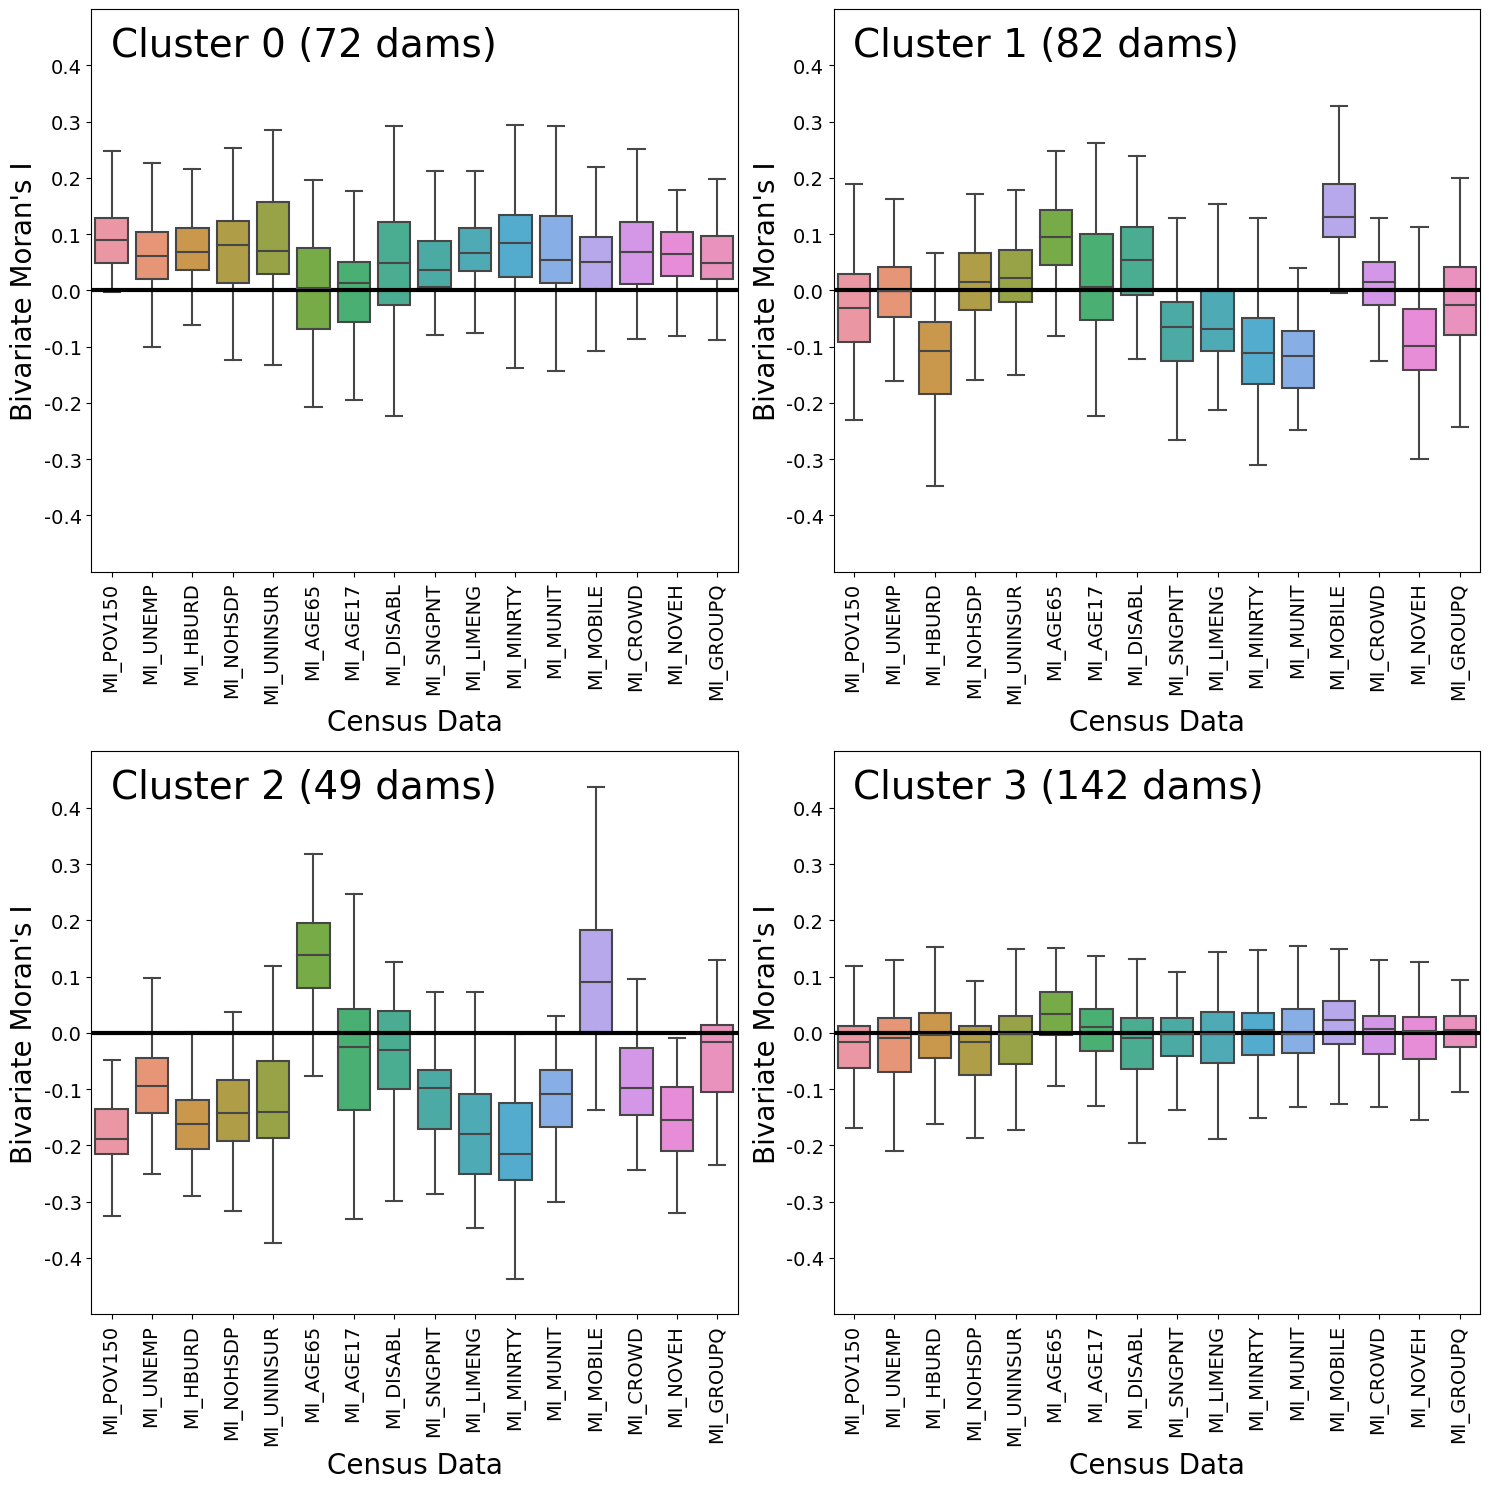

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.reshape(-1)

# Cluster 0: Positive correlation; Disadvantaged population
# Cluster 1: Mixture
# Cluster 2: Negative correlation; Advantaged population
# Cluster 3: No correlation
for c in range(4):
    temp_cluster = mi_.loc[mi_['cluster'] == c, [col for col in mi_.columns if col.startswith('MI')]].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=axes[c], showfliers=False)
    axes[c].set_ylim(-0.5, 0.5)
    axes[c].set_ylabel("Bivariate Moran's I", fontsize=20)
    axes[c].set_xlabel("Census Data", fontsize=20)
    axes[c].set_xticklabels([col for col in mi_.columns if col.startswith('MI')], rotation = 'vertical', fontsize=14)
    axes[c].set_yticks([v / 10 for v in range(-4, 5, 1)])
    axes[c].set_yticklabels([f"{v / 10}" for v in range(-4, 5, 1)], fontsize=14)
    axes[c].text(0.03, 0.97, f'Cluster {c} ({round(temp_cluster.shape[0]/16)} dams)', ha = 'left', va = 'top', fontsize=28, transform=axes[c].transAxes)
    axes[c].axhline(0, color='black', linewidth=3)
plt.tight_layout()

0 72
1 82
2 49
3 142


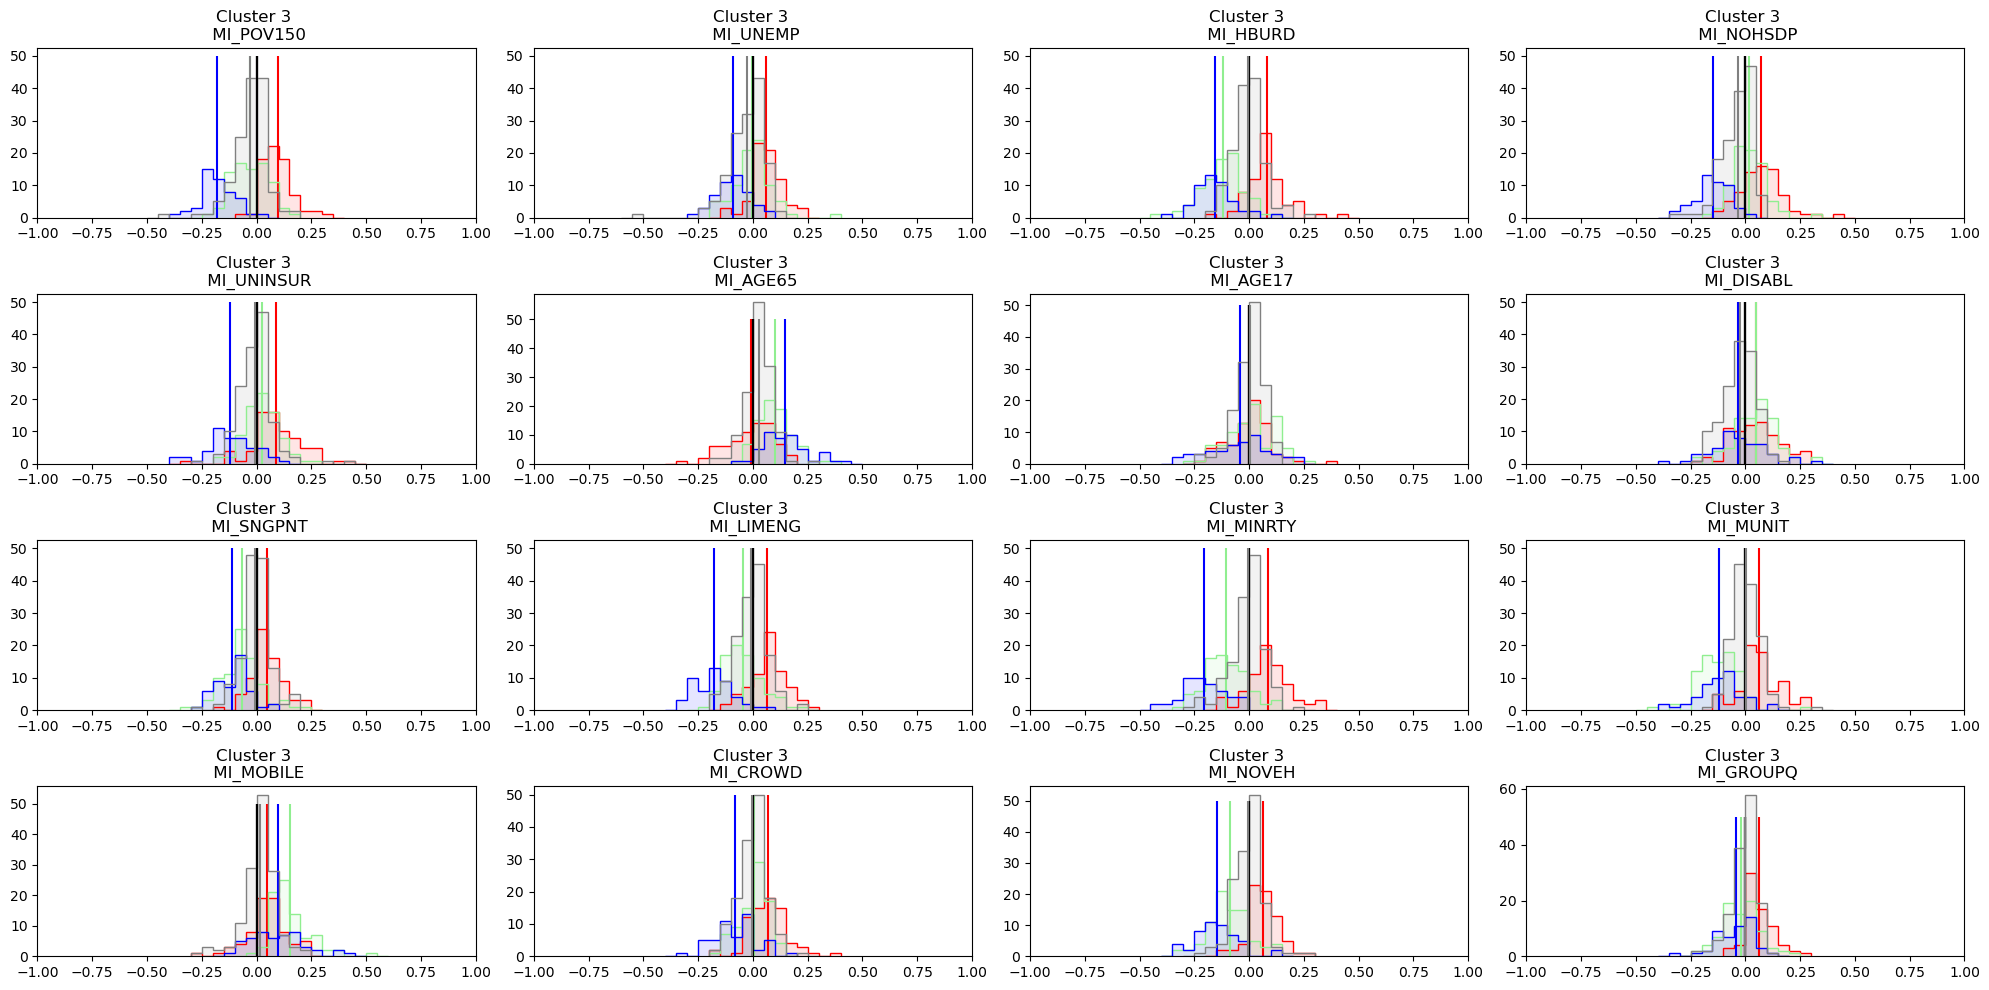

In [10]:
binwidth = 0.05
n = 10
colors = ['red','lightgreen','blue','grey']

fig, axes = plt.subplots(4, 4, figsize=(20, 10))
axes = axes.reshape(-1)

for c in range(0, 4, 1): 
    for col_idx, col in enumerate([col for col in mi_.columns if col.startswith('MI')]):
        temp_cluster_ = mi_.loc[mi_['cluster'] == c, [col]].values
        bins = np.arange(math.floor(min(temp_cluster_) * n) / n, math.ceil(max(temp_cluster_) * n) / n + binwidth, binwidth)
        axes[col_idx].hist(temp_cluster_, bins=bins, color=colors[c], histtype='stepfilled', alpha=0.1)
        axes[col_idx].hist(temp_cluster_, bins=bins, color=colors[c], histtype='step')
        axes[col_idx].set_xlim(-1, 1)
        
        ylim = axes[col_idx].get_ylim()[1]
        axes[col_idx].vlines(0, 0, 50, color='black')
        axes[col_idx].vlines(temp_cluster_.mean(), 0, 50, color=colors[c])
        axes[col_idx].set_title(f"Cluster {c} \n {col}")
    print(c, temp_cluster_.shape[0])
    plt.tight_layout()


## Geographical locations 

In [11]:
state = gpd.read_file('./census_geometry/tl_2022_us_state.shp')
state = state.merge(state_lookup, left_on='STUSPS', right_on='Abbr')
state = state.loc[state['ContiguousUS'] == 1]
state = state.to_crs(epsg=5070)

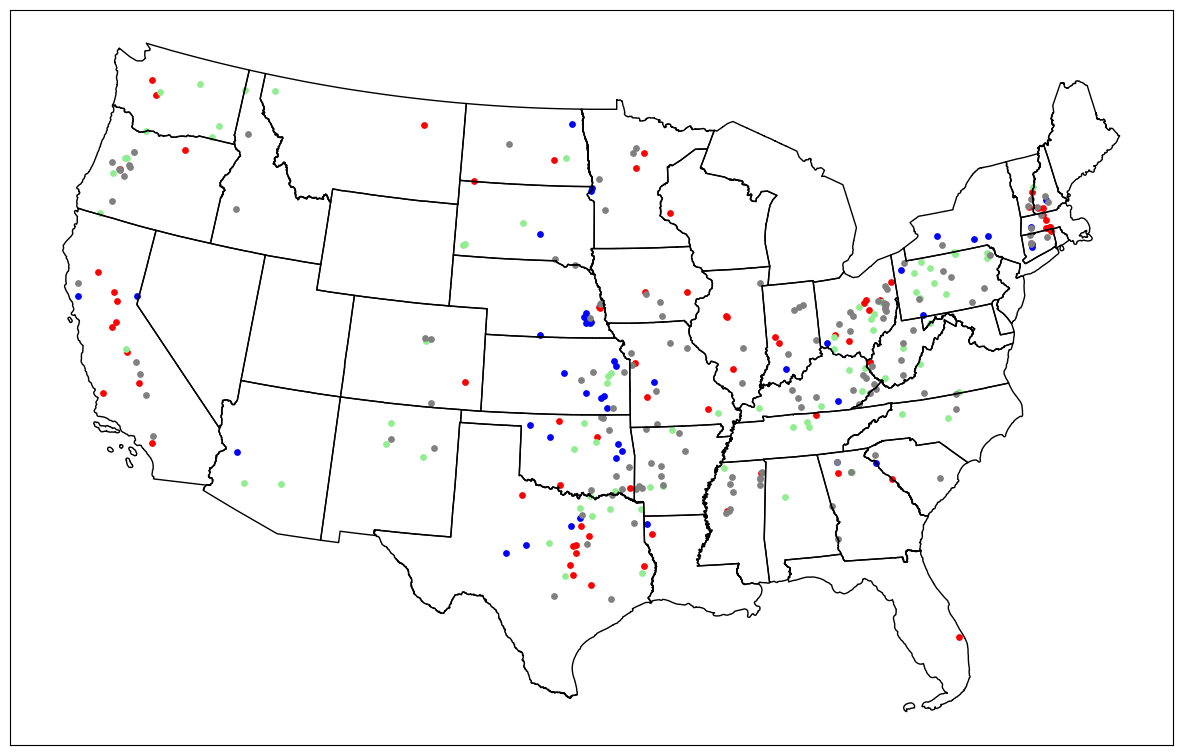

In [12]:
mi_plot = pd.concat([mi, mi_[['Component_1', 'Component_2', 'Component_3', 'Component_4', 'cluster']]], axis=1)
mi_plot = mi_plot.to_crs(epsg=5070)
mi_plot['cluster'] = mi_plot['cluster'].astype(str)

fig, ax = plt.subplots(figsize=(15,15))
state.boundary.plot(ax=ax, color='black', linewidth=1)

mi_plot.loc[mi_plot['cluster'] == '0'].plot(ax=ax, color='red', markersize=15)    # Positive correlation; Disadvantaged population
mi_plot.loc[mi_plot['cluster'] == '1'].plot(ax=ax, color='lightgreen', markersize=15) # Mixture
mi_plot.loc[mi_plot['cluster'] == '2'].plot(ax=ax, color='blue', markersize=15)   # Negative correlation; Advantaged population
mi_plot.loc[mi_plot['cluster'] == '3'].plot(ax=ax, color='grey', markersize=15)   # No correlation

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Local analysis results (Bivariate LISA)

In [13]:
def plot_bivariate_moran_i_and_local_moran_i(dam_id, lm_gdf, mi_gdf):
    fig, axes = plt.subplots(4, 4, figsize=(15, 20))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = lm_gdf.loc[lm_gdf['Dam_ID'] == dam_id].reset_index()

    inund_area = dam_area.loc[dam_area['Class'] > 0]
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    dam_focus = mi_gdf.loc[mi_gdf['ID'] == dam_id].reset_index()
    dam_focus = dam_focus.to_crs(epsg=5070)

    # Plot maps
    for m in range(16):
        lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'white'}

        for key in lisa_color.keys():
            lm_gdf.loc[(lm_gdf[f'{plot_cols_lm[m]}'] == key) & (lm_gdf['Dam_ID'] == dam_id)].plot(ax=ax[m], color=lisa_color[key], legend=True)

        ax[m].set_title(label=f"{plot_cols_lm[m]} \n({round(dam_focus[plot_cols_mi[m]].values[0], 2)})", fontsize=24)

        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.tight_layout()
    plt.show()
    


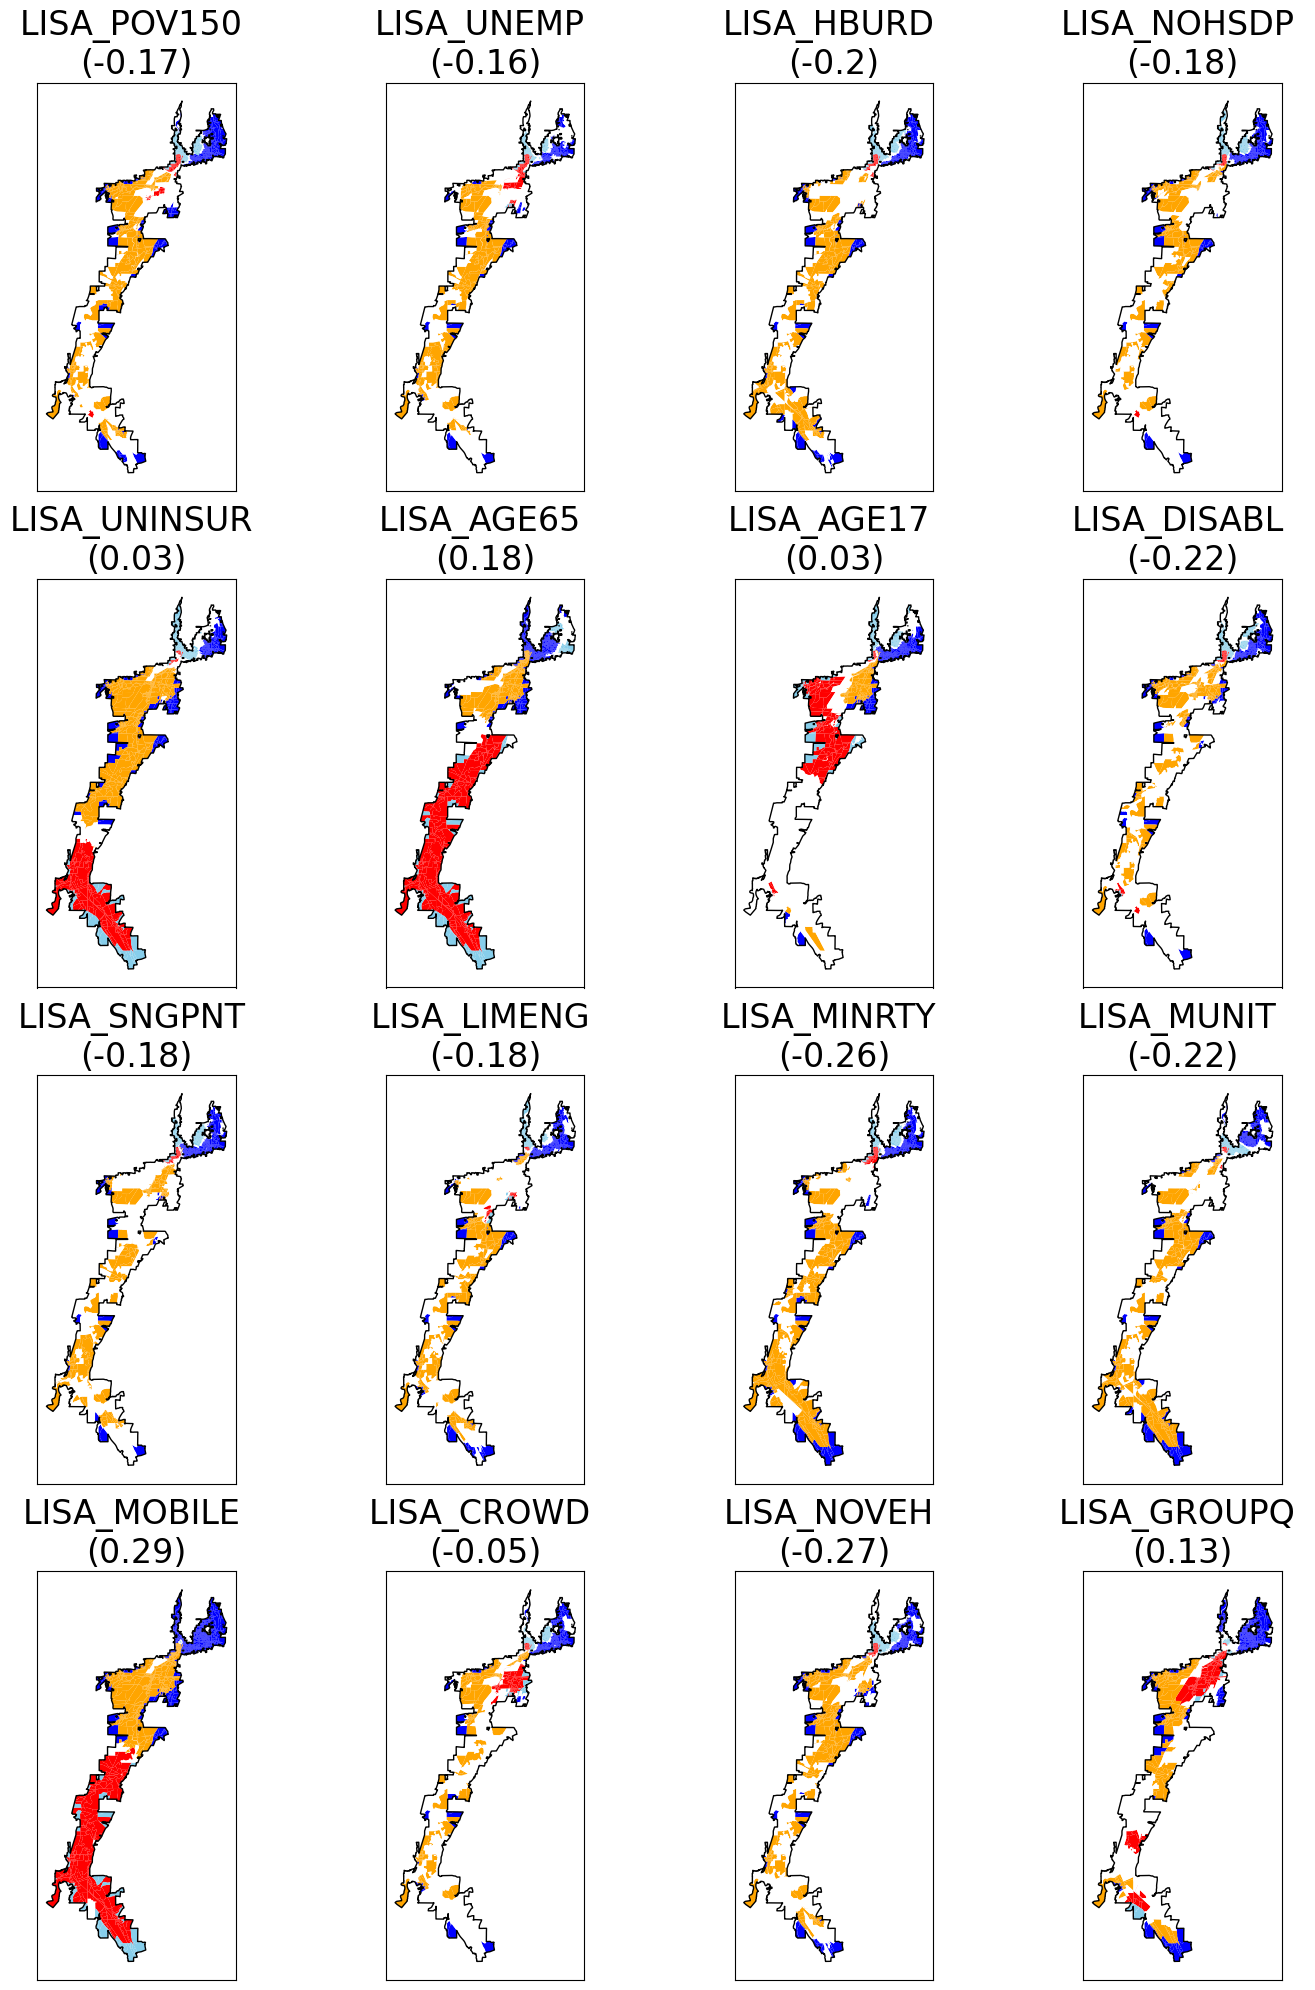

In [14]:
dam_id = 'NY00468'
iter_num = mi_plot.loc[mi['ID'] == dam_id, 'iter'].values[0]
lm_temp = gpd.read_file(os.path.join(output_path, f'N_{iter_num}', 'Multi_F_lm.geojson'))
plot_bivariate_moran_i_and_local_moran_i(dam_id, lm_temp, mi_plot)

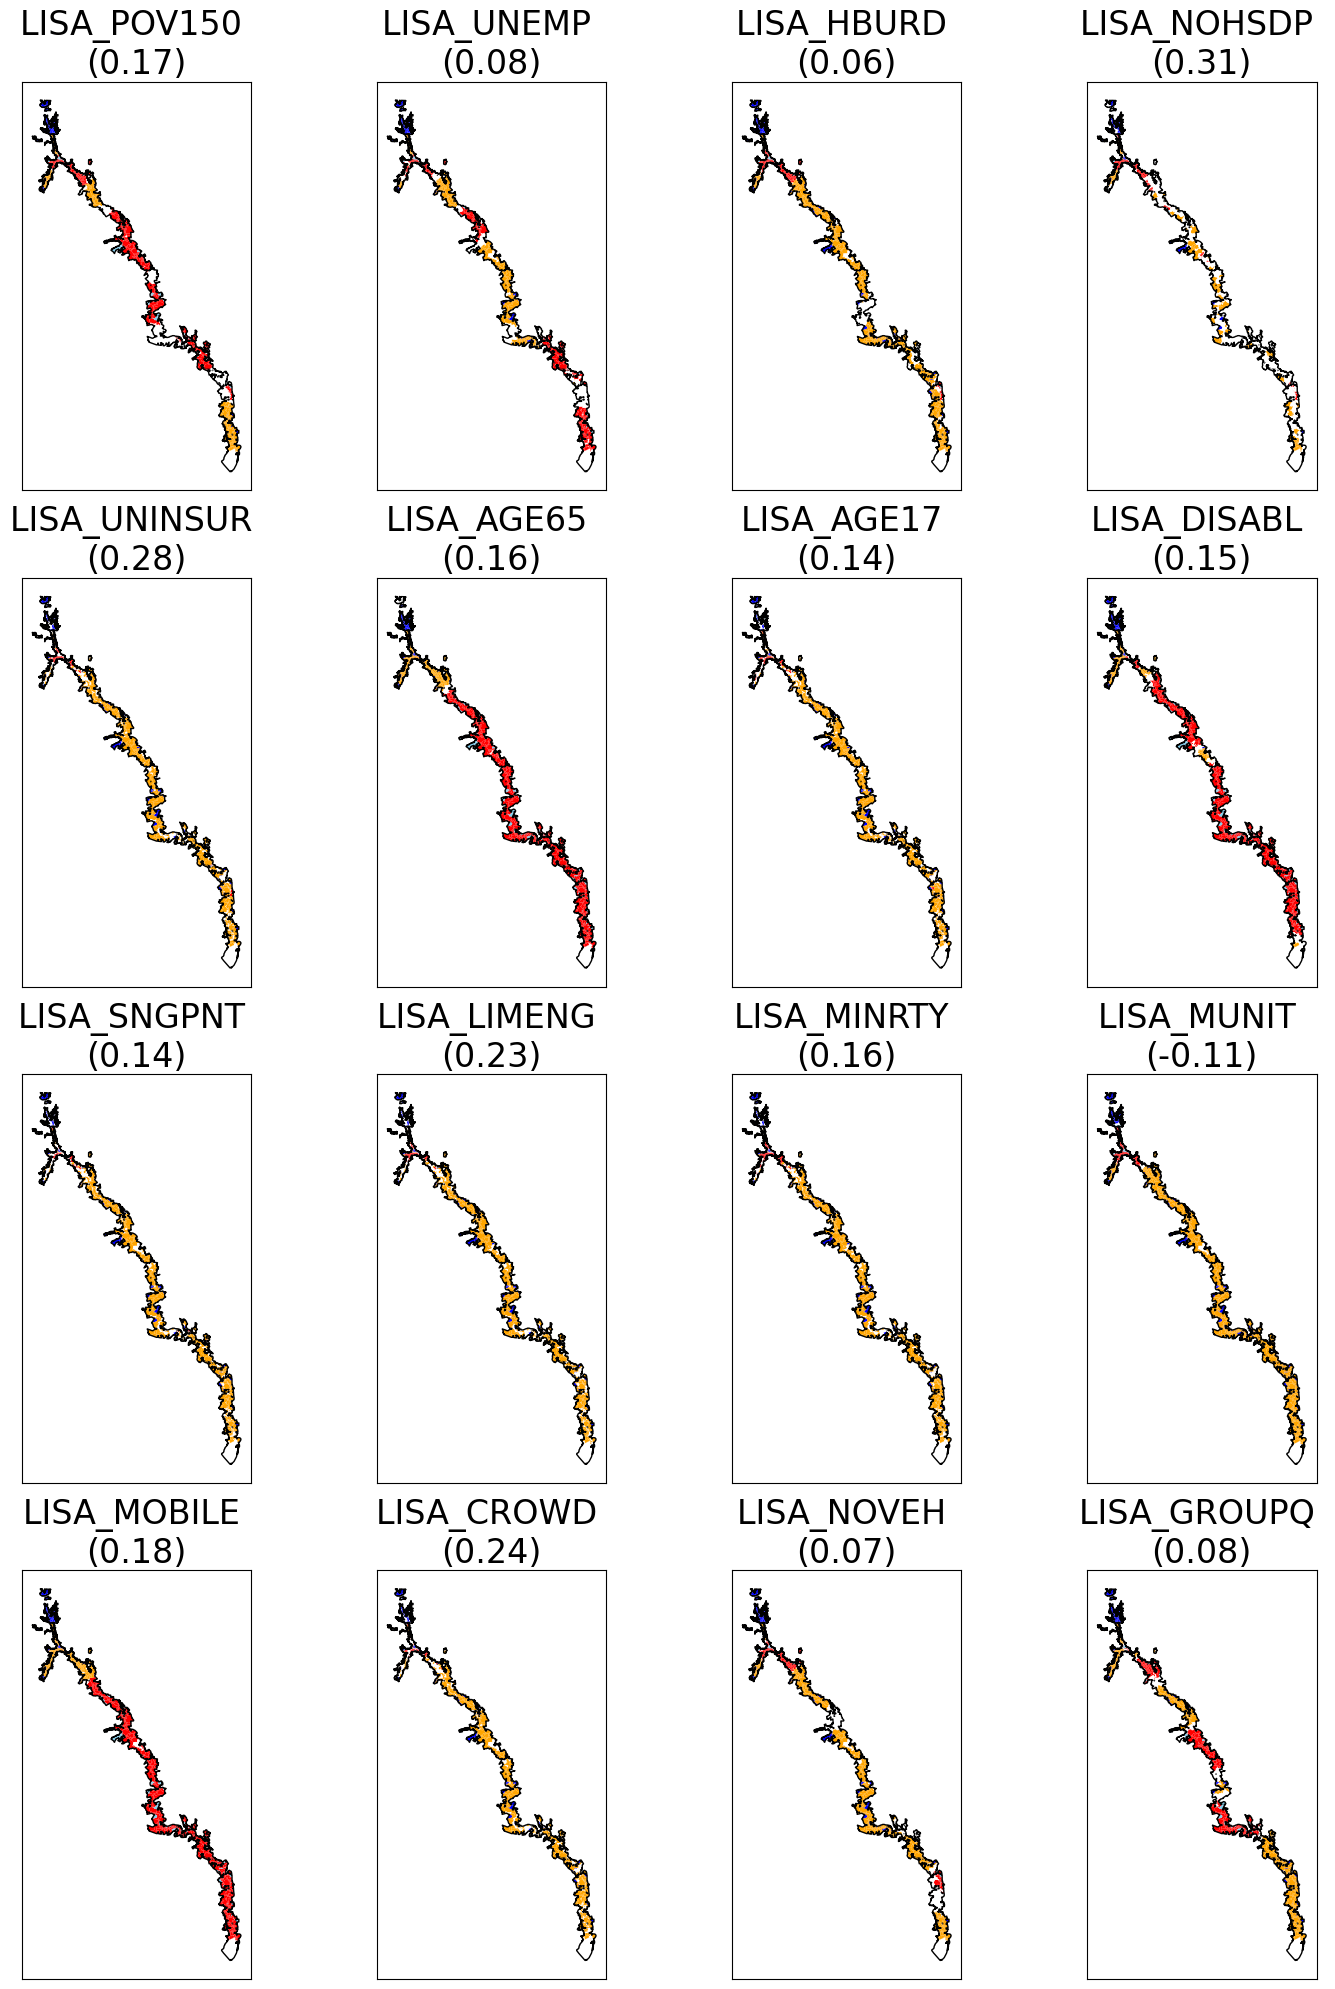

In [15]:
dam_id = 'TX08007'
iter_num = mi_plot.loc[mi['ID'] == dam_id, 'iter'].values[0]
lm_temp = gpd.read_file(os.path.join(output_path, f'N_{iter_num}', 'Multi_F_lm.geojson'))
plot_bivariate_moran_i_and_local_moran_i(dam_id, lm_temp, mi_plot)

# Done